# SPRINT 8 - Visualización de datos con Python

In [1]:
# Paso 1: conectar con la base de datos existente
import mysql.connector
import pandas as pd

def db_connect():
    try:
        if 'db' not in globals():
            global db
            db = mysql.connector.connect(host='localhost', database="mlg_sprint4", user="root", password="root")
            print("Conectado!")

    except Exception as e:
        exit("Error:", e)

# Aquí configurando cosas de genéricas de Pandas
pd.set_option("display.max.columns", None)
pd.options.mode.copy_on_write = True

## Tarea S08.01

### Nivel 1
Realitza la connexió en Python amb el MySQL Workbench per a carregar tota la informació que tens en les taules.

<div class="alert alert-block alert-warning">

**NOTA:**  
Esta descripción es un tanto confusa: Python **NO** se conecta con *MySQL Workbench*; se puede conectar con el **servidor** de base de datos (RDBMS: _Relational DataBase Management Server_) MySQL (o MariaDB, o PostgreSQL, o...). *MySQL Workbench* es un **cliente** (que sí, puede gestionar el servidor) que se conecta al RDBMS, igual que lo hará Python.  
Puede que parezca "más fácil de entender", pero sigue siendo incorrecto.

Si en una entrevista técnica el aspirante dijese eso, posiblemente perdería puntos.
</div>

Realitzaràs una visualització per a cada exercici. Comenta el que et crida l'atenció de graficar aquesta variable, justifica l'elecció del gràfic i interpreta els resultats en funció de les teves dades.

####

In [17]:
import sys

db_connect()

# extraer los datos de la DB. Iré añadiendo tablas según las vaya usando...
def load_tables():
    global tr_df, user_df, co_df
    try:
        if 'tr_df' not in globals() or type(tr_df) is not pd.core.frame.DataFrame:
            tr_df   = pd.read_sql("SELECT * FROM `transaction`", db)
            print("Tabla 'transaction' cargada correctamente")

        if 'user_df' not in globals() or type(user_df) is not pd.core.frame.DataFrame:
            user_df = pd.read_sql("SELECT * FROM `user`", db)
            print("Tabla 'user' cargada correctamente")

        if 'co_df' not in globals() or type(co_df) is not pd.core.frame.DataFrame:
            co_df = pd.read_sql("SELECT * FROM company", db)
            print("Tabla 'company' cargada correctamente")

    except ex:
        print(repr(sys.exception()))

load_tables()

#### T8.01 N1N1 Visualización de una variable numérica

He elegido representar las operaciones declinadas y completadas.

Para ello, hay que agrupar y contar las operaciones teniendo en cuenta si fueron completadas o no:
º

C:\Users\formacio\AppData\Local\Temp\ipykernel_12572\3459745482.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db, columns=["declined"])


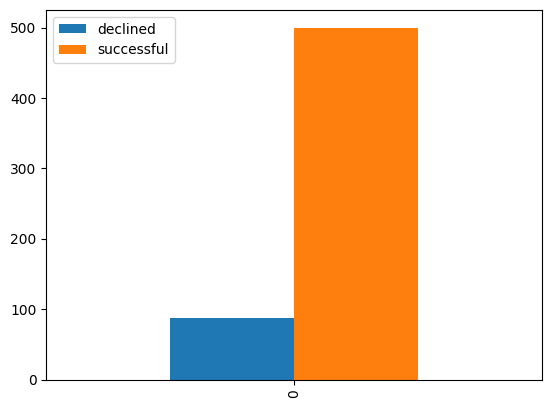

In [18]:
db_connect()

query = '''
SELECT SUM(declined)   AS declined
     , SUM(declined=0) AS successful
  FROM `transaction`
'''
if db and db.is_connected:
    df = pd.read_sql(query, con=db, columns=["declined"])
    df.plot.bar()

Aunque... supongo que si se trata de usar pandas, la idea es hacer la selección y agregación usando la biblioteca y no SQL, ya que la "_gracia_" está en importar datos de Excel, / hojas de cálculo, tablas HTML, CSV... donde no hay cómo hacer un GROUP BY o un MAX().
(Esto no se dice tampoco en el enunciado... Solo "conectar a la DB"; si conecto a una DB para hacer un select, a algunos la manipulación se nos va directamente a SQL).

<Axes: title={'center': 'Transactions'}, xlabel='Status', ylabel='# of transactions'>

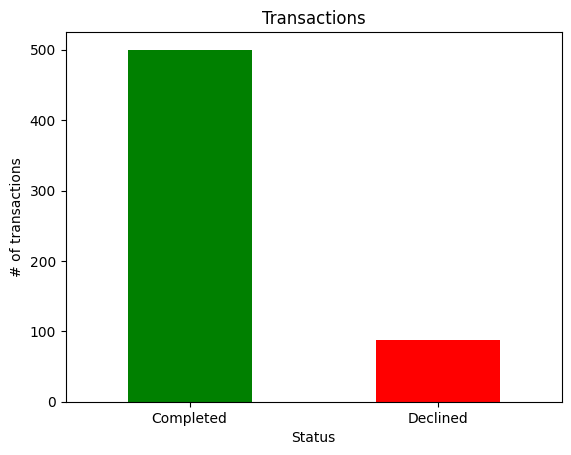

In [4]:
# Usando pandas para "calcular" las columnas, y crear el gráfico renombrando las columnas de "0" y "1" a "Completadas" y "Declinadas"ArithmeticErrordecl_df = tr_df.groupby('declined').count()
decl_df = tr_df.groupby('declined').count()

decl_df = decl_df.rename({0: "Completed", 1: "Declined"}, axis='index')['transaction_id']
# decl_df = decl_df['transaction_id']
# print(decl_df)
decl_df.plot.bar(
    title="Transactions",
    xlabel="Status",
    ylabel="# of transactions",
    color=['green', 'red'],
    rot=0
)

#### T8.01 N1N2 Visualización de dos variables numéricas

He añadido una nueva columna al dataset ("age"), para poder ver la distribución de edades de los compradores:

<Axes: title={'center': 'Age distribution'}, xlabel='Age', ylabel='# of Users'>

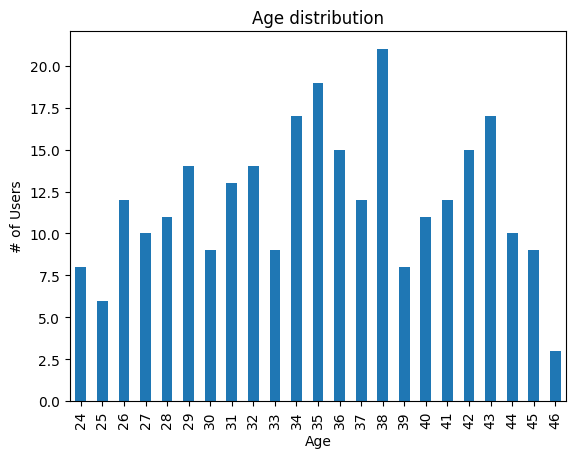

In [5]:
import dateutil

def age(birthdate: str):
    dob = birthdate if type(birthdate) is not str \
                  else dateutil.parser.parse(birthdate).date()
    hoy = dateutil.utils.today().date()
    ddiff = hoy - dob
    edad  = int(ddiff.days / 365.25)
    # print(edad, "años")
    return edad

# Add age column to user dataframe
user_df["age"] = user_df['birthdate'].map(age)

user_df.groupby('age')['age'] \
        .count() \
        .plot.bar(
            x='age',
            title="Age distribution",
            ylabel="# of Users",
            xlabel="Age"
        )

# user_df.age.plot.hist()


#### T8.01 N1N2 Una variable categòrica
Podríamos listar los países de las compañías...

<Axes: title={'center': "Companies' Countries"}, xlabel='Country', ylabel='Companies'>

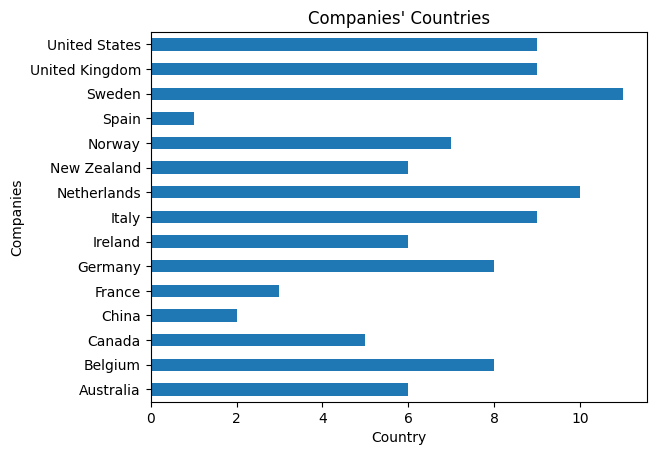

In [19]:
db_connect()

if db and db.is_connected:
    if 'co_df' not in globals() or type(co_df) is not pd.core.frame.DataFrame:
        load_tables()

co_df.groupby('country')['country'] \
        .count() \
        .plot.barh(
            x='age',
            title="Companies' Countries",
            ylabel="Companies",
            xlabel="Country"
        )

#### T8.01 N1N4 Una variable categòrica i una numèrica

Veamos... ¿Total de compras por país? Aquí, además, haría falta un `JOIN` entre `transaction` y `company`...

In [65]:
db_connect()

if db and db.is_connected:
    if 'co_df' not in globals() or type(co_df) is not pd.core.frame.DataFrame:
        load_tables()
tr_df.head()
co_df.head()
cotr_df = co_df.merge(tr_df, how='inner', on='company_id')

cotr_df.head()

,company_id,company_name,phone,email,country,website,transaction_id,user_id,credit_card_id,product_ids,transaction_ts,amount,latitude,longitude,declined
0,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site,108B1D1D-5B23-A76C-55EF-C568E49A05DD,275,CcU-2938,[59],2021-07-07 17:43:16,293.57,83.7839,-178.8600,0
1,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site,EA2C3281-C9C1-A387-44F8-729FB4B51C76,275,CcU-2938,"[59, 79, 37, 73]",2021-05-09 10:25:08,119.36,20.2004,-116.8400,1
2,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9,7DC26247-20EC-53FE-E555-B6C2E55CA5D5,275,CcU-2945,"[71, 41]",2022-02-04 15:52:56,312.50,58.9367,-76.8171,0
3,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9,FE96CE47-BD59-381C-4E18-E3CA3D44E8FF,275,CcU-2945,[3],2021-06-15 00:26:29,480.13,-21.8805,-112.5880,1
4,b-2230,Fusce Corp.,08 14 97 58 85,risus@protonmail.edu,United States,https://pinterest.com/sub/cars,72997E96-DC2C-A4D7-7C24-66C302F8AE5A,275,CcU-2952,"[97, 41, 3]",2022-01-30 15:16:36,239.87,43.3584,-17.6580,0


<Axes: xlabel='country', ylabel='Income by country'>

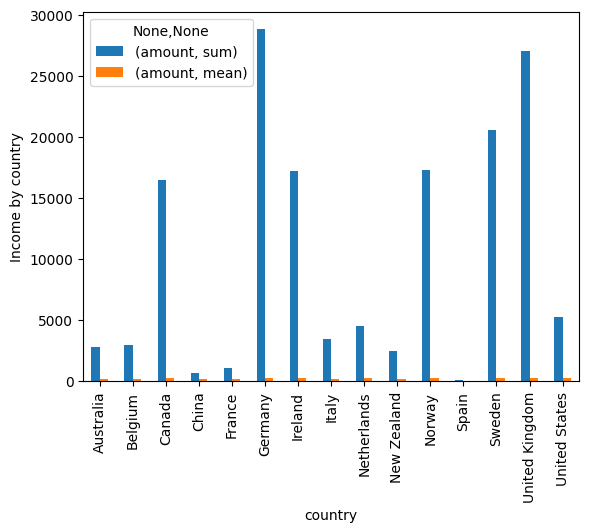

In [68]:
company_amounts = cotr_df.get(['country', 'amount']).groupby('country').agg(['sum', 'mean'])
company_amounts.plot.bar(ylabel="Income by country")